# Transfer Learning using Tensorflow 2 #
First, import tensorflow 2.0

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf


TensorFlow 2.x selected.


## Download, Unzip and import the dataset ##
Ideally, the dataset should have files in ./train and ./test to make importing the files easier. Alternately, different methods can be used to import the images rather than flow_from_directory

To download and unzip simply make a wget request to the dataset and unzip the downloaded file using command line(!):



In [0]:
!wget -O "dataset.zip" "https://www.dropbox.com/s/qdptwne9j43z70d/dataset_split.zip"

--2020-02-07 16:25:00--  https://www.dropbox.com/s/qdptwne9j43z70d/dataset_split.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qdptwne9j43z70d/dataset_split.zip [following]
--2020-02-07 16:25:01--  https://www.dropbox.com/s/raw/qdptwne9j43z70d/dataset_split.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce50401ff07434dac50c977e3ef.dl.dropboxusercontent.com/cd/0/inline/AxpeSGCW_bkwrKdUUeARF6Xaj_b38afLJKEbKRkPgI3UavVM-pZnDiBMADXzuTIF7_5ps4dosoFO37-EmWhe5xhCTTJyYSF_y8SbXBbcS0HW890KbiW9Krb18-vCwV1hxbM/file# [following]
--2020-02-07 16:25:01--  https://uce50401ff07434dac50c977e3ef.dl.dropboxusercontent.com/cd/0/inline/AxpeSGCW_bkwrKdUUeARF6Xaj_b38afLJKEbKRkPgI3UavVM-pZnDiBMADXzuTIF7_5ps4dosoFO37-EmWhe5xhCTTJyYSF_y8S

In [0]:
%%capture
!unzip "/content/dataset.zip"


Using Image data generator and flow_from_directory from tf.keras.preprocessing, import the dataset (and repeat for the test set):



In [0]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator=train_datagen.flow_from_directory('/content/train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)


## Load the pretrained model of choice ##
Choose a model from the following link: https://www.tensorflow.org/api_docs/python/tf/keras/applications In the sample code, we chose to use the Xception model. First, we need to import the different objects we are going to need:


In [0]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

Load the model, add a Global Average Pooling layer to the output, followed by 2 Densely conneced networks, one with activation relu and the other with softmax. The softmax layer will give the actual output.


In [0]:
base_model=Xception(weights='imagenet',include_top=False)
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
preds=Dense(18,activation='softmax')(x) #final layer with softmax activation


83689472/83683744 [==============================] - 1s 0us/step


In [0]:
model=Model(inputs=base_model.input,outputs=preds)


## Compile, Train, and Test the model ##
Compile the model with the settings of your choice, for the optimizer, loss and metrics. Then, use model.fit to train it.


In [0]:
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])


In [0]:
step_size_train=train_generator.n//train_generator.batch_size
model.fit(train_generator,
          steps_per_epoch=step_size_train,
          epochs=10)


  ...
    to  
  ['...']
Train for 390 steps
Epoch 1/10
390/390 [==============================] - 250s 641ms/step - loss: 2.0423 - accuracy: 0.4204
Epoch 2/10
390/390 [==============================] - 239s 613ms/step - loss: 0.8889 - accuracy: 0.7726
Epoch 3/10
  6/390 [..............................] - ETA: 4:00 - loss: 0.5527 - accuracy: 0.8594

To test the model, call model.evaluate and it will return the result based on the metrics chosen during compilation:



In [0]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

test_generator=test_datagen.flow_from_directory('/content/test',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)
model.evaluate(test_generator)


Found 1800 images belonging to 18 classes.
  ...
    to  
  ['...']
57/57 [==============================] - 8s 139ms/step - loss: 0.7343 - accuracy: 0.8289


[0.7342749653678191, 0.8288889]

## Export the model ##
Save the model using model.save. Make sure that the model is an object of class tensorflow.keras.models.Model.



In [0]:
import tensorflow as tf
model.save('RESNET_model.h5')  
saved_model_path = "/content/saved_models/"
tf.keras.models.save_model(model, saved_model_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/saved_models/assets


In [0]:
print(model.metrics_names) # Check out the metrics that were used

['loss', 'accuracy']


## Visualizing the testing process ##
Test the model by loading in images, converting them into the target size, loading them as np arrays, and preprocessing them in the same manner as the input, and plotting the image with the result

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np
%matplotlib inline

def test_with(test_file_path):
  img = image.load_img(test_file_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BravoHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']
  plt.imshow(img)
  plt.show()
  print('Predicted:', preds.argmax(axis=-1), class_names[preds.argmax(axis=-1)[0]])

Few test samples:

In [0]:
%%capture
!wget -O "testTh.jpg" "https://www.studenthealth.virginia.edu/sites/studenthealth.virginia.edu/files/Thornton_Hall_Spring_17_SS_01.jpg"

!wget -O "testRot.jpg" "https://upload.wikimedia.org/wikipedia/commons/b/bf/Rotunda_UVa_from_the_south_east.jpg"

!wget -O "testCh.jpg" "https://eventplanning.odos.virginia.edu/sites/eventplanning.odos.virginia.edu/files/chapel_0.jpg"

!wget -O "testR.jpg" "https://media.glassdoor.com/l/d7/f4/d2/5d/rice-hall-computer-science.jpg"

!wget -O "testNw.jpg" "https://eventplanning.odos.virginia.edu/sites/eventplanning.odos.virginia.edu/files/newcomb.jpg"

!wget -O "testNC.jpg" "https://news.virginia.edu/sites/default/files/styles/uva_basic_article/public/article_image/14697_photo_1_high_res.jpg"

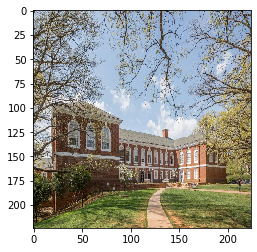

Predicted: [16] ThorntonHall


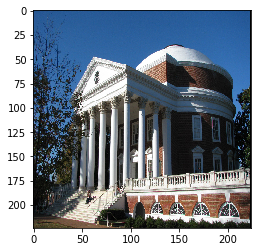

Predicted: [14] Rotunda


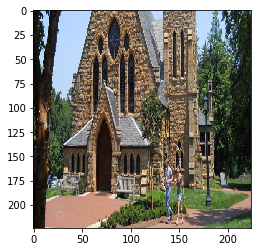

Predicted: [17] UniversityChapel


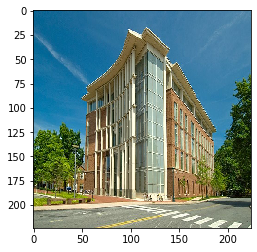

Predicted: [13] RiceHall


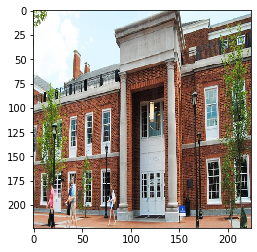

Predicted: [6] ClarkHall


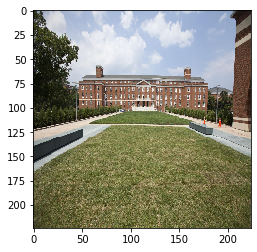

Predicted: [9] NewCabellHall


In [0]:
test_with("./testTh.jpg")
test_with("./testRot.jpg")
test_with("./testCh.jpg")
test_with("./testR.jpg")
test_with("./testNw.jpg")
test_with("./testNC.jpg")

## Convert the model into a tensorflow JS model##
First, you need to install the command line tool for tensorflowjs:



In [0]:
!pip install tensorflowjs

Now, use tensorflowjs_converter to convert the keras model to a tensorflow js ready folder:


In [0]:
!tensorflowjs_converter --input_format keras /content/model_name.h5 /content/output_folder_name

## Final Steps ##
Once you have the folder created, download and host the folder to a service where you can use a file path. An instance of such a cloud service is Github. The file path system, which does not function with Google Drive, Box, and DropBox, is essential, as tensorflowjs only takes in the URL to the json file created, and the binary files are pulled in subsequent request using the file location.

